StockFactor(normalized=True,names=['valuation_augment'],dates=20170105-20241224)

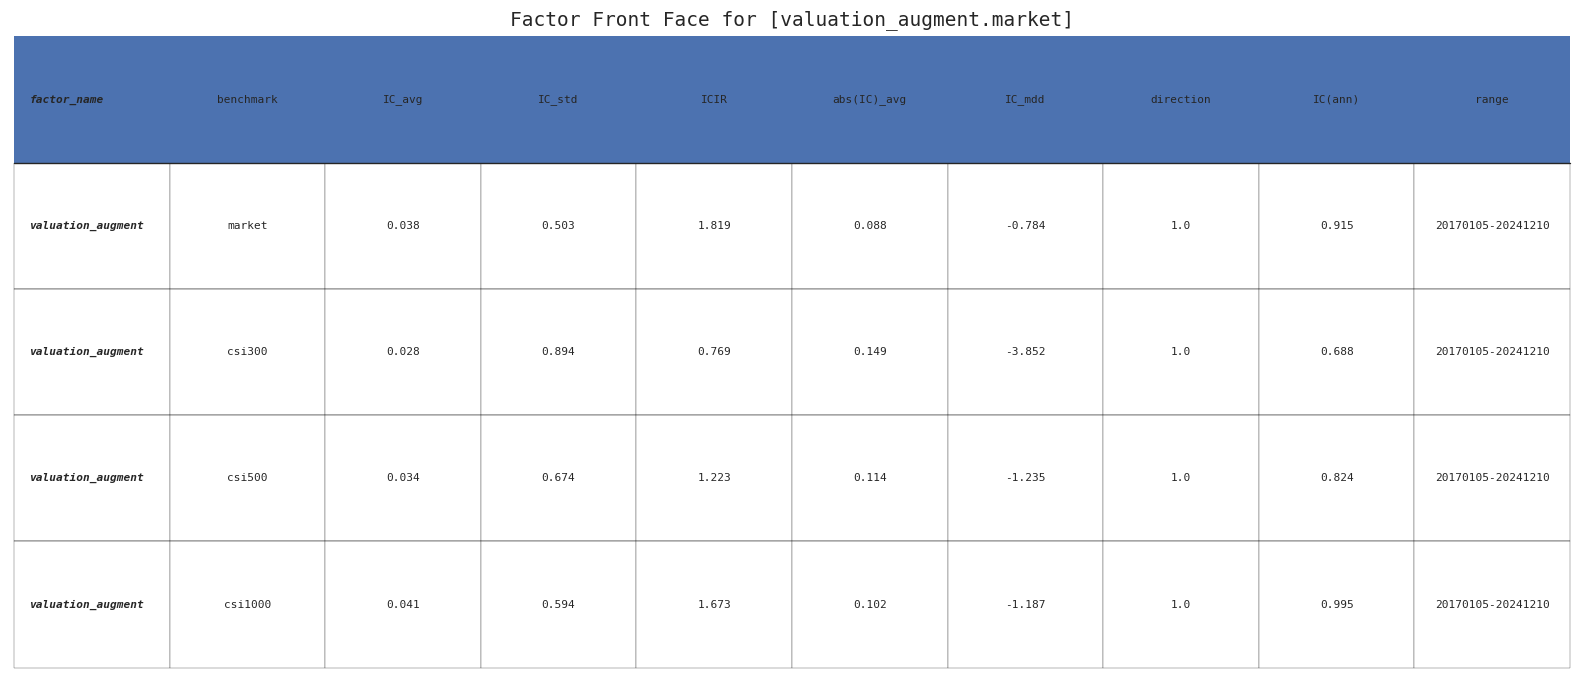

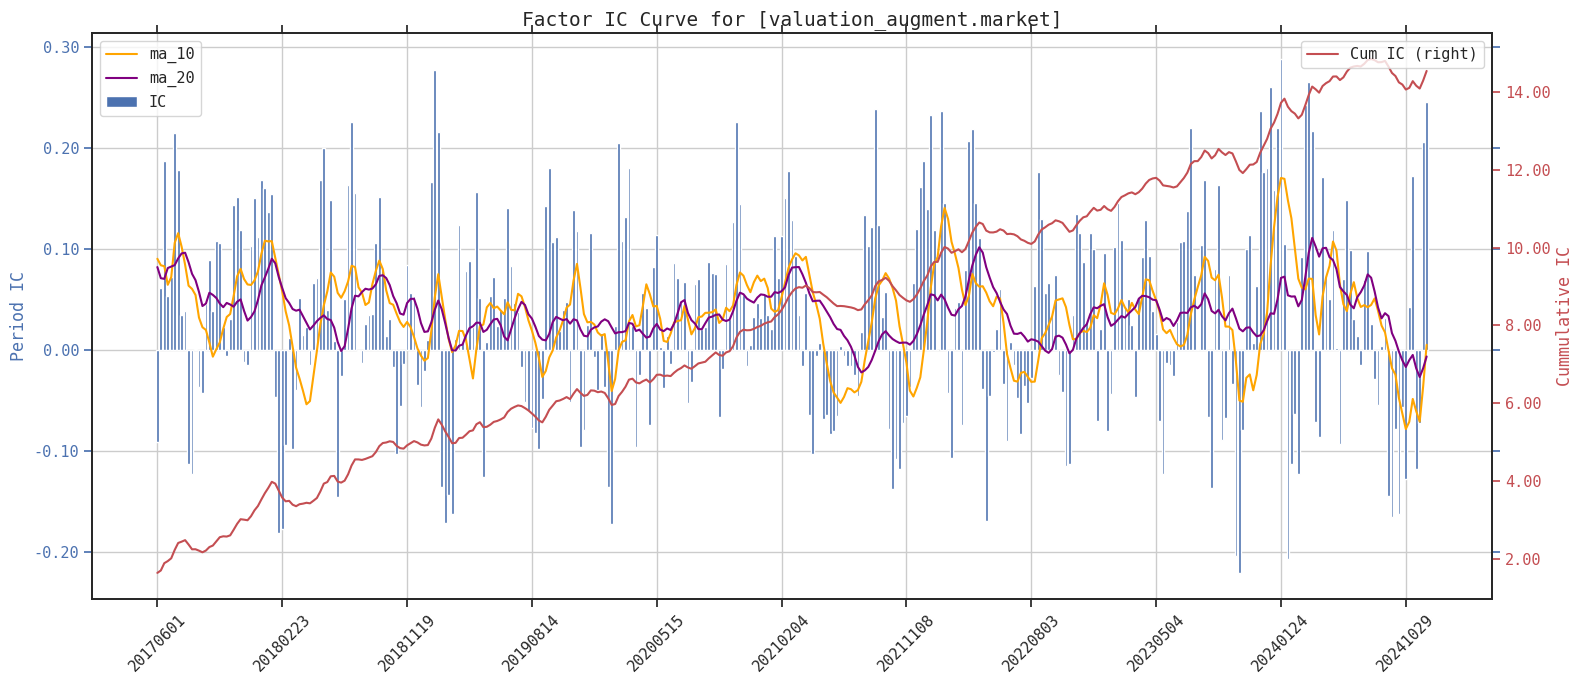

In [2]:
from src.api import FactorAPI
FactorAPI.FastAnalyze('valuation_augment' , start = 20170101 , step = 5 , lag = 1)


In [15]:
from src.factor.util.classes.stock_factor import melt_frame
import numpy as np
import pandas as pd
def weighted_mean(v , weight = None):
    if weight is not None:
        weight = np.nan_to_num(weight)
        return np.sum(v * weight , axis = None) / (np.sum(weight , axis = None) + 1e-6)
    else:
        return np.mean(v , axis = None)

def whiten(v : pd.DataFrame | pd.Series | np.ndarray , weight = None):
    stdev = np.std(v) if isinstance(v , np.ndarray) else np.std(v.to_numpy().flatten()) + 1e-6
    mean = weighted_mean(v , weight)
    return (v - mean) / stdev

df = melt_frame(factor.frame())
df.groupby(by=['date' , 'factor_name']).transform(whiten)


value
date     secid  factor_name                
20180102 1      valuation_augment  1.511014
         2      valuation_augment -0.710693
         4      valuation_augment -0.431055
         5      valuation_augment -0.138809
         6      valuation_augment -1.826551
...                                     ...
20241219 920002 valuation_augment -0.138956
         920016 valuation_augment -1.235139
         920019 valuation_augment -0.695963
         920099 valuation_augment -0.953640
         920118 valuation_augment -1.114235

[1377053 rows x 1 columns]

StockFactor(normalized=False,names=['etop'],dates=20180102-20241219)

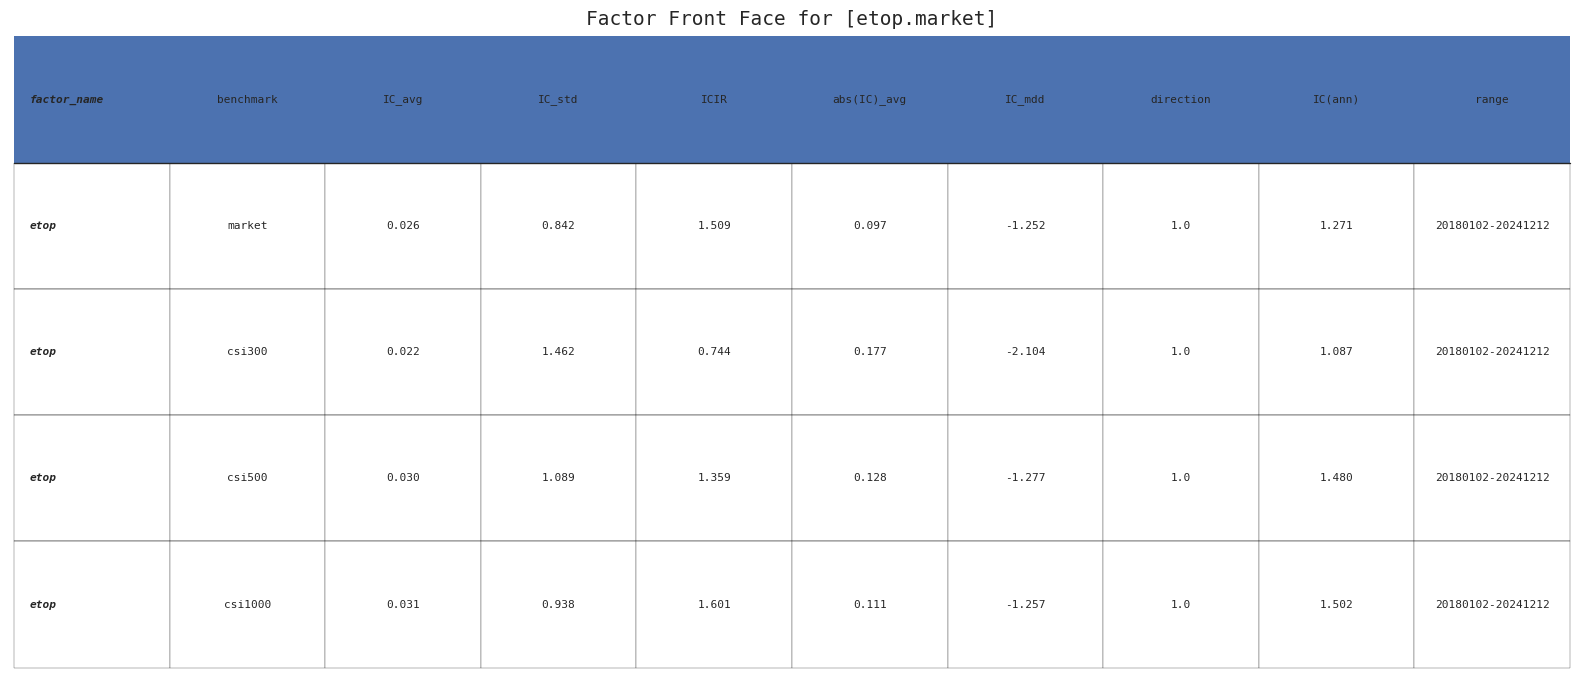

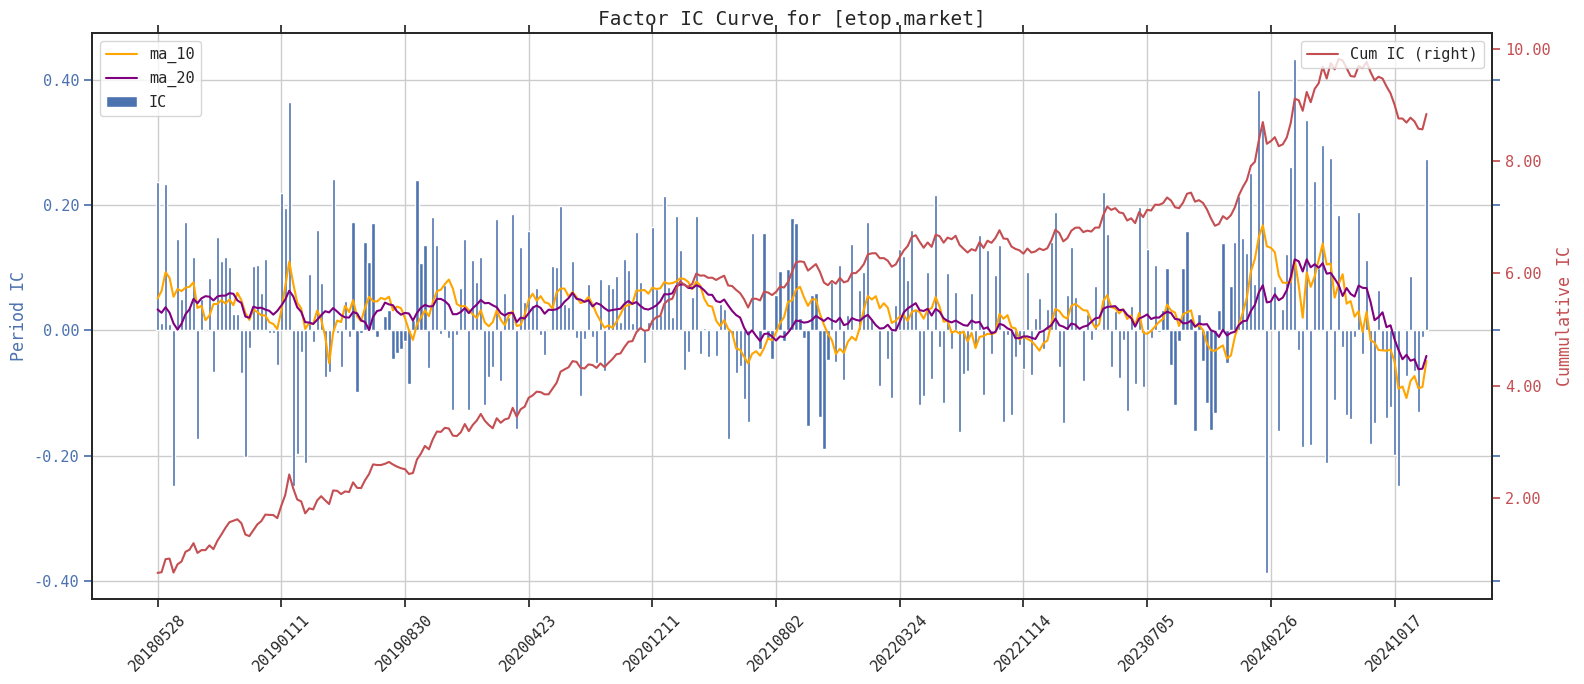

In [2]:
factor.fast_analyze(lag = 1 , nday = 5)

In [54]:
df = factor.frame()
df

,,etop
secid,date,
1,20180102,0.028053
2,20180102,0.010540
4,20180102,-0.000886
6,20180102,NaN
7,20180102,NaN
...,...,...
920106,20241219,0.007408
920111,20241219,0.008361
920118,20241219,0.005969


In [48]:
ic = factor.eval_ic(lag = 1 , nday = 5)


In [45]:
import pandas as pd
import numpy as np
def eval_stats(x):
    assert isinstance(x , pd.DataFrame) , type(x)
    x_sum = x.sum().rename('sum')
    x_avg = x.mean().rename('avg')
    x_std = x.std().rename('std')
    x_abs_avg = x.abs().mean().rename('abs_avg')
    x_ir = (x_avg / x_std).rename('ir')
    x_cumsum = x.cumsum()
    x_maxdown = (x_cumsum - x_cumsum.cummax()).min().rename('cum_mdd')
    return pd.concat([x_sum, x_avg , x_std, x_ir, x_abs_avg , x_maxdown], axis=1, sort=True)

def eval_ic_stats(ic_table : pd.DataFrame , nday : int = 5):
    n_periods  = 243 / nday
    
    ic_stats   = eval_stats(ic_table).reset_index(drop=False)

    ic_stats['direction'] = np.sign(ic_stats['avg'])
    ic_stats['year_ret'] = ic_stats['avg'] * n_periods
    ic_stats['std']      = ic_stats['std'] * np.sqrt(n_periods)
    ic_stats['ir']       = ic_stats['ir'] * np.sqrt(n_periods)

    melt_table = ic_table.reset_index().melt(id_vars=['date'],var_name='factor_name',value_name='ic').dropna().reset_index()
    min_date = melt_table.groupby('factor_name')['date'].min()
    max_date = melt_table.groupby('factor_name')['date'].max()

    range_date = pd.concat([min_date.rename('start') , max_date.rename('end')] , axis=1).reset_index()
    range_date['range'] = range_date['start'].astype(str) + '-' + range_date['end'].astype(str)

    ic_stats = ic_stats.merge(range_date[['factor_name','range']] , on='factor_name')
    return ic_stats

eval_ic_stats(ic)

,factor_name,sum,avg,std,ir,abs_avg,cum_mdd,direction,year_ret,range
0,etop,1.675495,0.004957,0.451129,0.534025,0.047567,-1.076769,1.0,0.240914,20180102-20241212


In [65]:
from src.data import DATAVENDOR
from cProfile import Profile
nday = 5
lag = 1
ret_type = 'close'
secid = df.index.get_level_values('secid').unique().values
date = df.index.get_level_values('date').unique().values
old_index = df.index.names




In [69]:
import torch
date_min = DATAVENDOR.td(date.min() , -10).td
date_max = DATAVENDOR.td(int(date.max()) , nday + lag + 10).td

td_within = DATAVENDOR.CALENDAR.slice(DATAVENDOR.td_within(date_min , date_max) , None , DATAVENDOR.CALENDAR.updated())
if (not hasattr(DATAVENDOR , 'day_ret')) or (not np.isin(td_within , DATAVENDOR.day_ret.date).all()):
    print(np.setdiff1d(td_within , DATAVENDOR.day_ret.date))




In [59]:
df[df.index.get_level_values('date') == 20241212].to_csv('etop.csv')

In [61]:
factors = ['etop']
ic_type = 'spearman'
ic = df.dropna(subset=['ret']).groupby(by=['date'], as_index=True).apply(lambda x:x[factors].corrwith(x['ret'], method=ic_type))
ic.rename_axis('factor_name',axis='columns')

ic.mean()

etop    0.026144
dtype: float64

In [16]:
ic.sum()

etop    0.470928
dtype: float64

In [46]:
from src.factor.analytic.factor_perf.calculator import Factor_FrontFace
front = Factor_FrontFace(lag = 1 , nday = 5)
front.calc(factor)
front.calc_rslt


sum       avg       std        ir   abs_avg  \
factor_name benchmark                                                     
etop        market     0.385790  0.001145  0.340100  0.081794  0.051092   
            csi300    -0.615942 -0.001828  0.867709 -0.051185  0.141698   
            csi500     3.058333  0.009075  0.572683  0.385076  0.091388   
            csi1000    1.971153  0.005849  0.506886  0.280405  0.078183   

                        cum_mdd  direction  year_ret              range  
factor_name benchmark                                                    
etop        market    -1.710829        1.0  0.027818  20180102-20241205  
            csi300    -5.904401       -1.0 -0.044414  20180102-20241205  
            csi500    -1.923293        1.0  0.220527  20180102-20241205  
            csi1000   -1.716062        1.0  0.142134  20180102-20241205

In [47]:
from src.factor.analytic.factor_perf.stat import calc_factor_frontface
calc_factor_frontface(factor , nday = 5 , lag = 1 , ic_type = 'pearson' , ret_type = 'close')

,factor_name,sum,avg,std,ir,abs_avg,cum_mdd,direction,year_ret,range
0,etop,1.675495,0.004957,0.451129,0.534025,0.047567,-1.076769,1.0,0.240914,20180102-20241212


StockFactor(normalized=False,names=['etop'],dates=20180102-20241219)

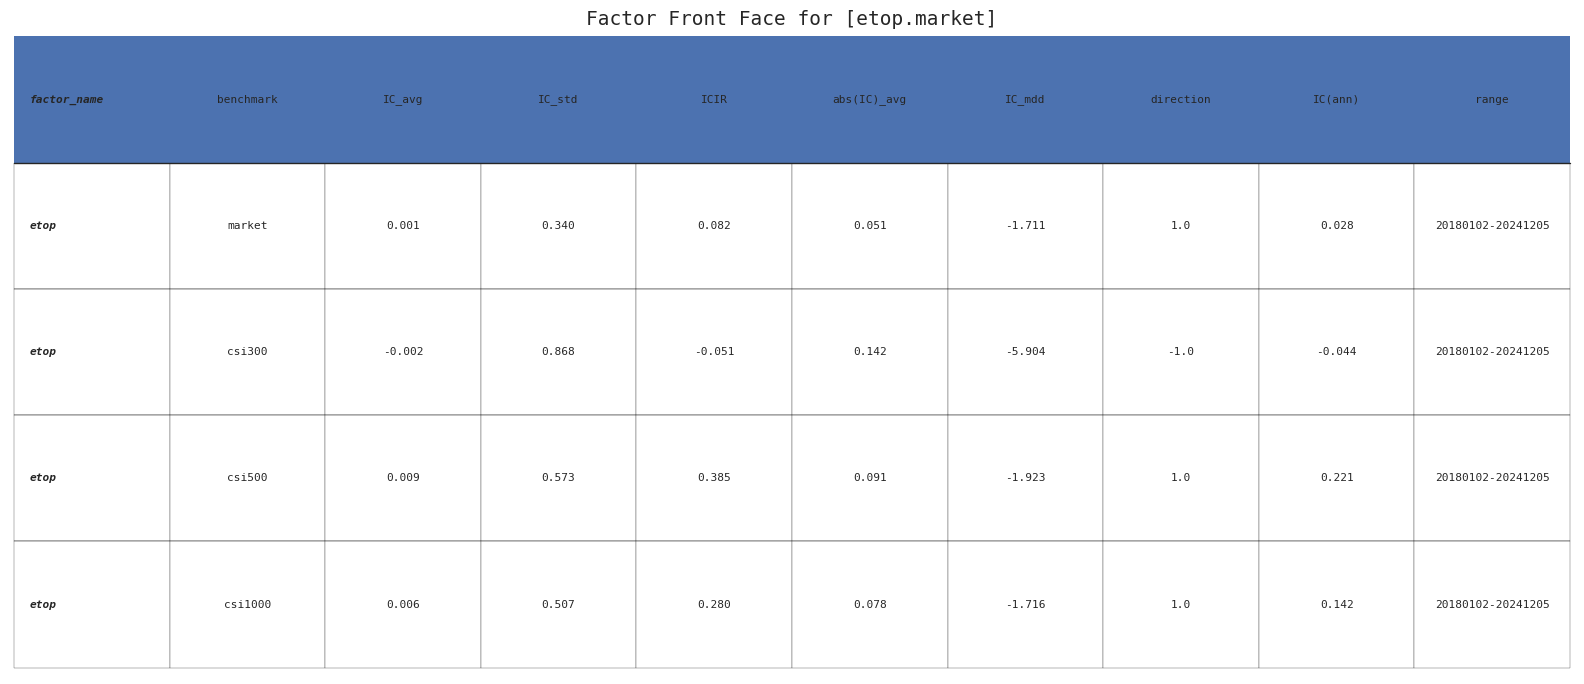

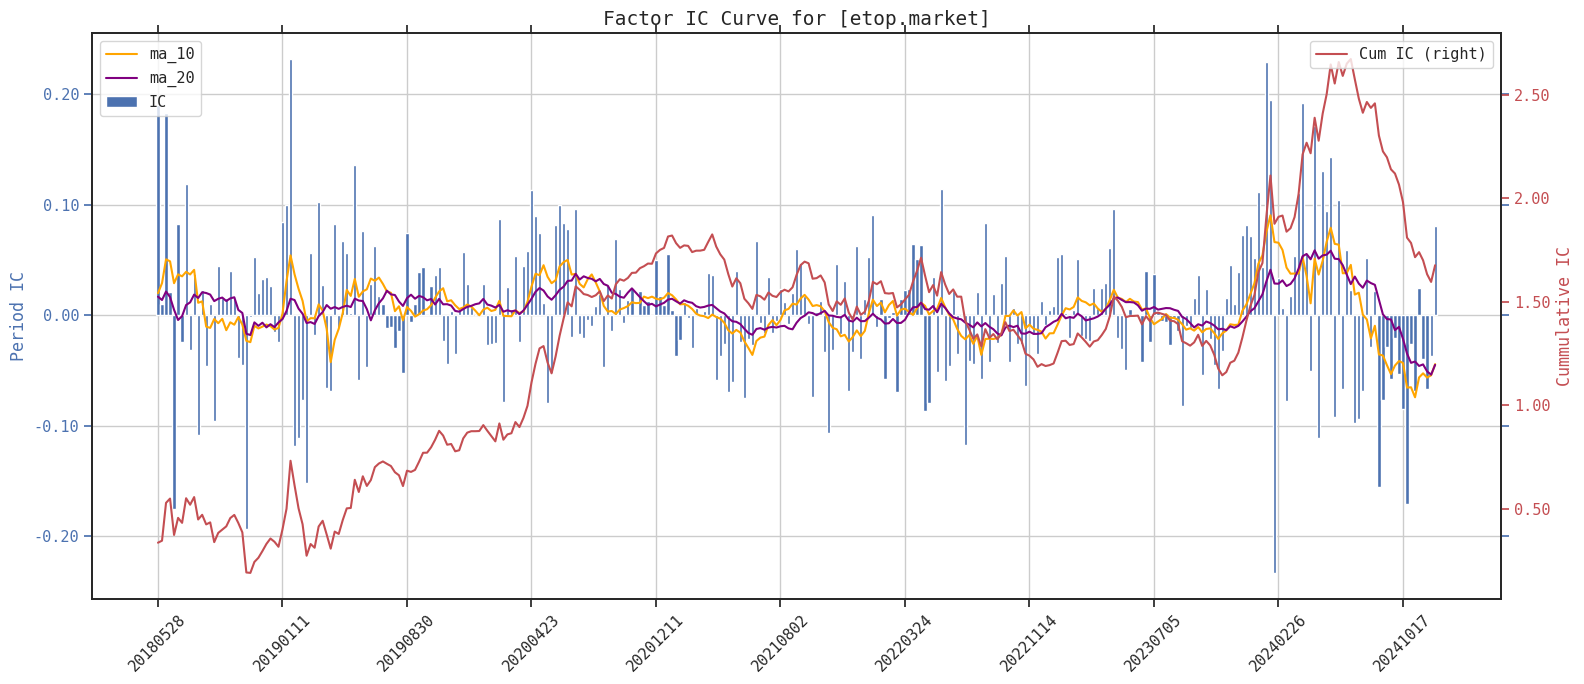

In [19]:
factor.fast_analyze(lag = 1 , nday = 5)

In [14]:
from cProfile import Profile
from src.basic import PATH
with Profile() as pr:
    d = PATH.factor_dates('dedt_equ_ttm')
pr.print_stats('cumtime')
d


         7846 function calls (7768 primitive calls) in 0.014 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.014    0.014 data_interface.py:250(factor_dates)
        1    0.000    0.000    0.014    0.014 data_interface.py:68(dir_dates)
        1    0.000    0.000    0.012    0.012 data_interface.py:57(list_files)
        1    0.000    0.000    0.008    0.008 data_interface.py:62(<listcomp>)
      223    0.001    0.000    0.007    0.000 pathlib.py:569(_parse_args)
      223    0.004    0.000    0.006    0.000 pathlib.py:56(parse_parts)
        1    0.000    0.000    0.004    0.004 data_interface.py:65(<listcomp>)
       74    0.001    0.000    0.004    0.000 pathlib.py:791(relative_to)
       74    0.000    0.000    0.003    0.000 pathlib.py:957(__new__)
       74    0.000    0.000    0.003    0.000 pathlib.py:589(_from_parts)
      8/4    0.000    0.000    0.003    0.001 os.py:345(_walk)
 

array([20110104, 20110111, 20110118, 20110125, 20110201, 20110215,
       20110222, 20110301, 20110308, 20110315, 20110322, 20110329,
       20110407, 20110414, 20110421, 20110428, 20110506, 20110513,
       20110520, 20110527, 20110603, 20110613, 20110620, 20110627,
       20110704, 20110711, 20110718, 20110725, 20110801, 20110808,
       20110815, 20110822, 20110829, 20110905, 20110913, 20110920,
       20110927, 20111011, 20111018, 20111025, 20111101, 20111108,
       20111115, 20111122, 20111129, 20111206, 20111213, 20111220,
       20111227, 20120105, 20120112, 20120119, 20120202, 20120209,
       20120216, 20120223, 20120301, 20120308, 20120315, 20120322,
       20120329, 20120410, 20120417, 20120424, 20120503, 20120510,
       20120517, 20120524, 20120531, 20120607, 20120614, 20120621,
       20120629, 20120706])

In [ ]:
from src.basic import PATH
with Profile() as pr:
    d = PATH.factor_dates('dedt_equ_ttm')
pr.print_stats('tottime')

In [3]:
from src.factor.calculator import StockFactorHierarchy
hier = StockFactorHierarchy()
calcs = hier.iter_instance(**{})

In [1]:
from src.api import FactorAPI
hier = FactorAPI.Hierarchy()
hier.factor_df()['file_name'].unique()


src.INSTANCE_RECORD can be accessed to check ['trainer', 'account']
Basic module imported!


array(['analyst\\adjustment', 'analyst\\coverage', 'analyst\\forecast',
       'analyst\\surprise', 'behavior\\behavior_anndt',
       'behavior\\behavior_ff3', 'behavior\\behavior_slice',
       'behavior\\correlation_beta', 'behavior\\correlation_vp',
       'behavior\\liquidity_cap', 'behavior\\liquidity_cv',
       'behavior\\liquidity_illiquid', 'behavior\\liquidity_turnover',
       'behavior\\momentum_classic', 'behavior\\momentum_mdr',
       'behavior\\momentum_phigh', 'behavior\\momentum_weivol',
       'behavior\\volatility_exret', 'behavior\\volatility_ret',
       'behavior\\volatility_skew', 'fundamental\\earning_classic',
       'fundamental\\earning_sue', 'fundamental\\earning_tsreg',
       'fundamental\\growth_acc', 'fundamental\\growth_classic',
       'fundamental\\growth_long', 'fundamental\\growth_rankdelta',
       'fundamental\\growth_trend', 'fundamental\\growth_yoyzscore',
       'fundamental\\quality', 'fundamental\\valuation_dynamic',
       'fundamental\\va

In [2]:
factor_values = hier.test_calc_all_factors(ignore_error = False , verbose = True) # file_name = ''fundamental\\valuation_augment'' , 

uppct_npro_3m calculated , valid_ratio is 44.47%
upnum_npro_3m calculated , valid_ratio is 44.47%
upnum_npro_6m calculated , valid_ratio is 46.97%
rec_npro_3m calculated , valid_ratio is 44.47%
rec_npro_6m calculated , valid_ratio is 46.95%
upnum_npro_12m calculated , valid_ratio is 53.50%
cov_inst_3m calculated , valid_ratio is 100.00%
uppct_npro_12m calculated , valid_ratio is 53.50%
rec_npro_12m calculated , valid_ratio is 53.48%
cov_inst_12m calculated , valid_ratio is 100.00%
cov_report_3m calculated , valid_ratio is 100.00%
uppct_npro_6m calculated , valid_ratio is 46.97%
cov_inst_6m calculated , valid_ratio is 100.00%
cov_report_6m calculated , valid_ratio is 100.00%
cov_report_12m calculated , valid_ratio is 100.00%
upnum_npro_6m_anndt calculated , valid_ratio is 42.38%
rec_npro_6m_anndt calculated , valid_ratio is 42.35%
cov_inst_12m_anndt calculated , valid_ratio is 100.00%
uppct_npro_6m_anndt calculated , valid_ratio is 42.38%
eps_est_pct3m calculated , valid_ratio is 56.52%

In [ ]:
factor_values = hier.test_calc_all_factors(category0 = 'analyst' , multi_thread = True) # file_name = 'moneyflow/holding' , 

src.INSTANCE_RECORD can be accessed to check ['trainer', 'account']
Basic module imported!
etop_augment at 20241213 calculated
etop_augment at 20241115 calculated
etop_augment at 20241101 calculated
etop_augment at 20241129 calculated


StockFactor(normalized=False,names=['etop_augment'],dates=20241101-20241213)

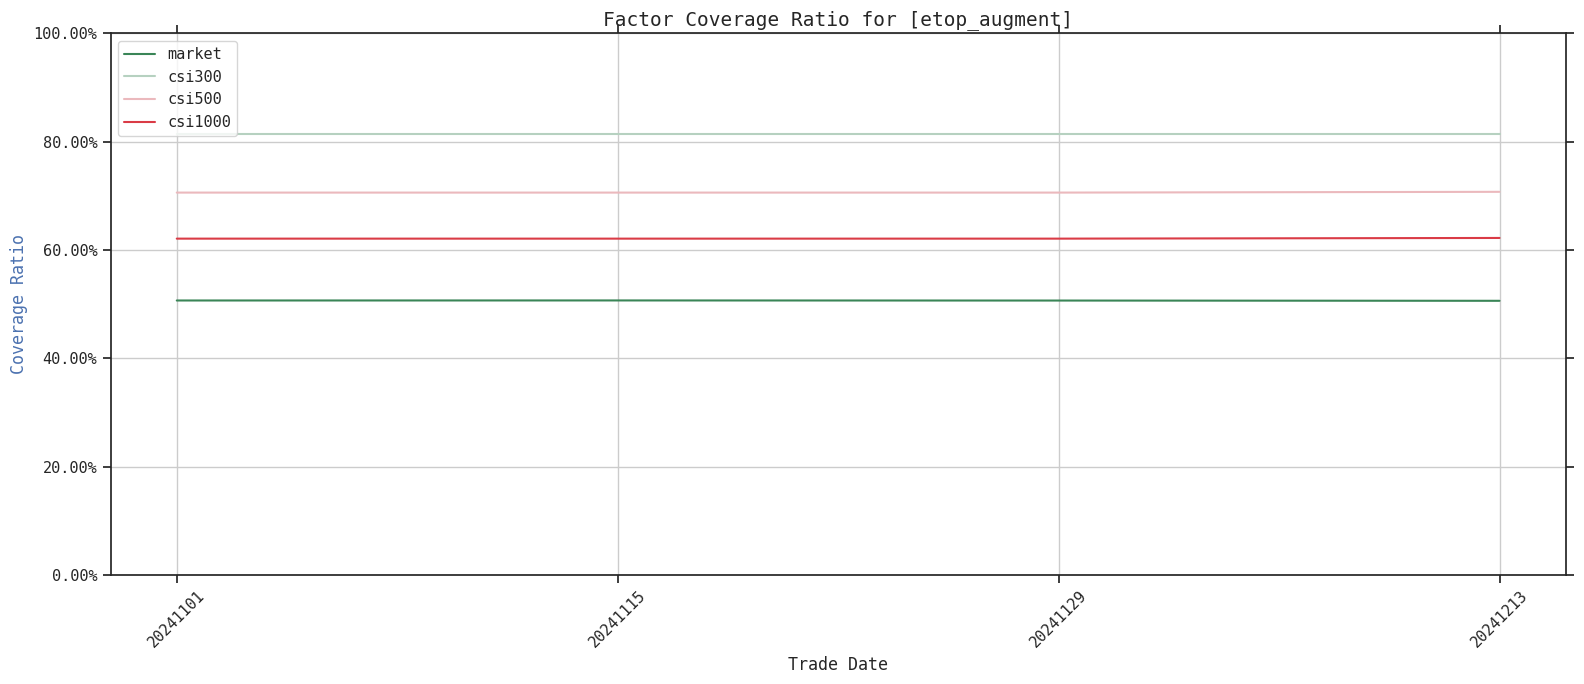

In [1]:
from src.api import FactorAPI
hier = FactorAPI.Hierarchy()
calc = hier.get_factor('etop_augment')
factor = calc.Factor(20241101 , multi_thread=True)
factor.analyze('Coverage')

In [7]:
hier.get_factor('ff_alpha_1m')().calc_factor(20241203)


secid
1         0.001472
2        -0.003134
4        -0.006647
6        -0.001304
7        -0.004757
            ...   
920088   -0.001742
920099    0.000018
920111    0.012260
920118    0.010361
920128   -0.002829
Name: ff_alpha_1m, Length: 5372, dtype: float64

In [2]:
from src_factor_definition.level1.fundamental.valuation_augment import btop_augment
btop_augment.Calc(20240620)

secid
1              NaN
2              NaN
4              NaN
6              NaN
7        -0.539658
            ...   
873706         NaN
873726   -0.173380
873806         NaN
873833         NaN
920002         NaN
Name: btop_augment, Length: 5365, dtype: float64

In [3]:
from src.factor.analytic.factor_perf.calculator import Factor_IC_Curve
calc = Factor_IC_Curve()
calc.calc(factor)
calc.calc_rslt

date        ic    cum_ic     ma_10     ma_20
factor_name  benchmark                                                  
btop_augment market     20240102  0.159530  0.159530       NaN       NaN
             market     20240116  0.184942  0.344472       NaN       NaN
             market     20240130 -0.029805  0.314667       NaN       NaN
             market     20240221 -0.159847  0.154820       NaN       NaN
             market     20240306 -0.015496  0.139324       NaN       NaN
...                          ...       ...       ...       ...       ...
             csi1000    20241021  0.016872  0.441610  0.031856  0.022080
             csi1000    20241104  0.178215  0.619825  0.053347  0.017056
             csi1000    20241118 -0.051258  0.568567  0.022584 -0.001386
             csi1000    20241202       NaN       NaN       NaN       NaN
             csi1000    20241216       NaN       NaN       NaN       NaN

[96 rows x 5 columns]

{'btop_augment.market': <Figure size 1600x700 with 2 Axes>,
 'btop_augment.csi300': <Figure size 1600x700 with 2 Axes>,
 'btop_augment.csi500': <Figure size 1600x700 with 2 Axes>,
 'btop_augment.csi1000': <Figure size 1600x700 with 2 Axes>}

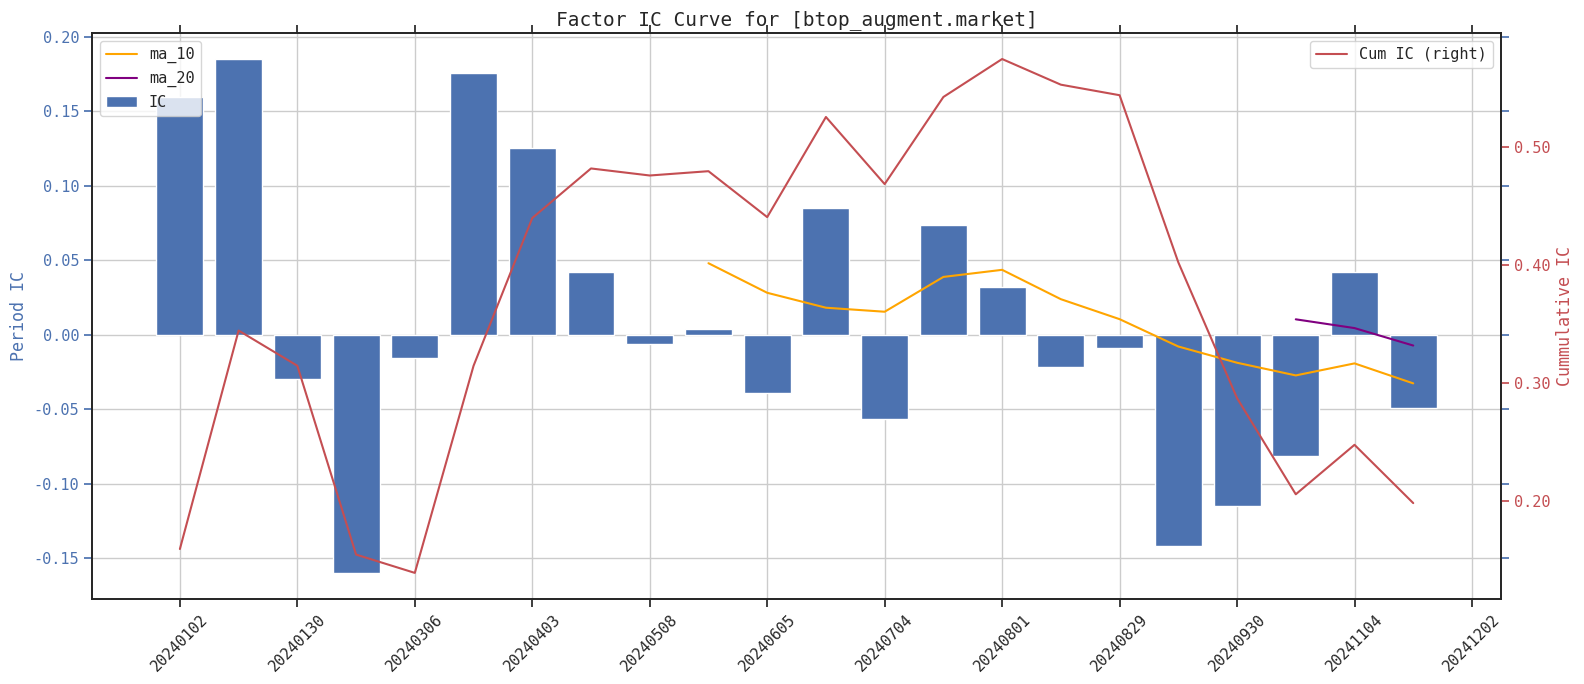

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from src.factor.util.plot import plot_table , get_twin_axes , set_xaxis , set_yaxis , PlotMultipleData , PlotFactorData , sns_lineplot , sns_barplot

def plot_factor_ic_curve(data : pd.DataFrame , show = False):
    group_plot = PlotMultipleData(data , group_key = ['factor_name' , 'benchmark'])
    for i , sub_data in enumerate(group_plot):     
        with PlotFactorData(sub_data , title = 'Factor IC Curve' , dropna = False , show=show and i==0) as (df , fig):
            df = df.set_index('date').sort_index()
            ax1 , ax2 = get_twin_axes(fig , 111)

            ax1.bar(df.index, df['ic'], color='b', label='IC')
            colors = ['orange','purple','olive','pink','cyan','grey','azure','yellow']
            for col in df.columns.tolist():
                if col.startswith('ma_'): ax1.plot(df.index, df[col], color=colors.pop(0) , label=col)  
            ax1.legend(loc='upper left')

            ax2.plot(df.index, df['cum_ic'], 'r-', label='Cum IC (right)')  
            ax2.legend(loc='upper right')  

            set_xaxis(ax1 , df.index)
            set_yaxis(ax1 , format='flt' , digits=2 , title = 'Period IC' , title_color='b' , tick_color='b')
            set_yaxis(ax2 , format='flt' , digits=2 , title = 'Cummulative IC' , title_color='r' , tick_color='r' , tick_pos=None)
            
    return group_plot.fig_dict

plot_factor_ic_curve(calc.calc_rslt , True)

StockFactor(normalized=True,names=['btop_augment'],dates=20240102-20241216)

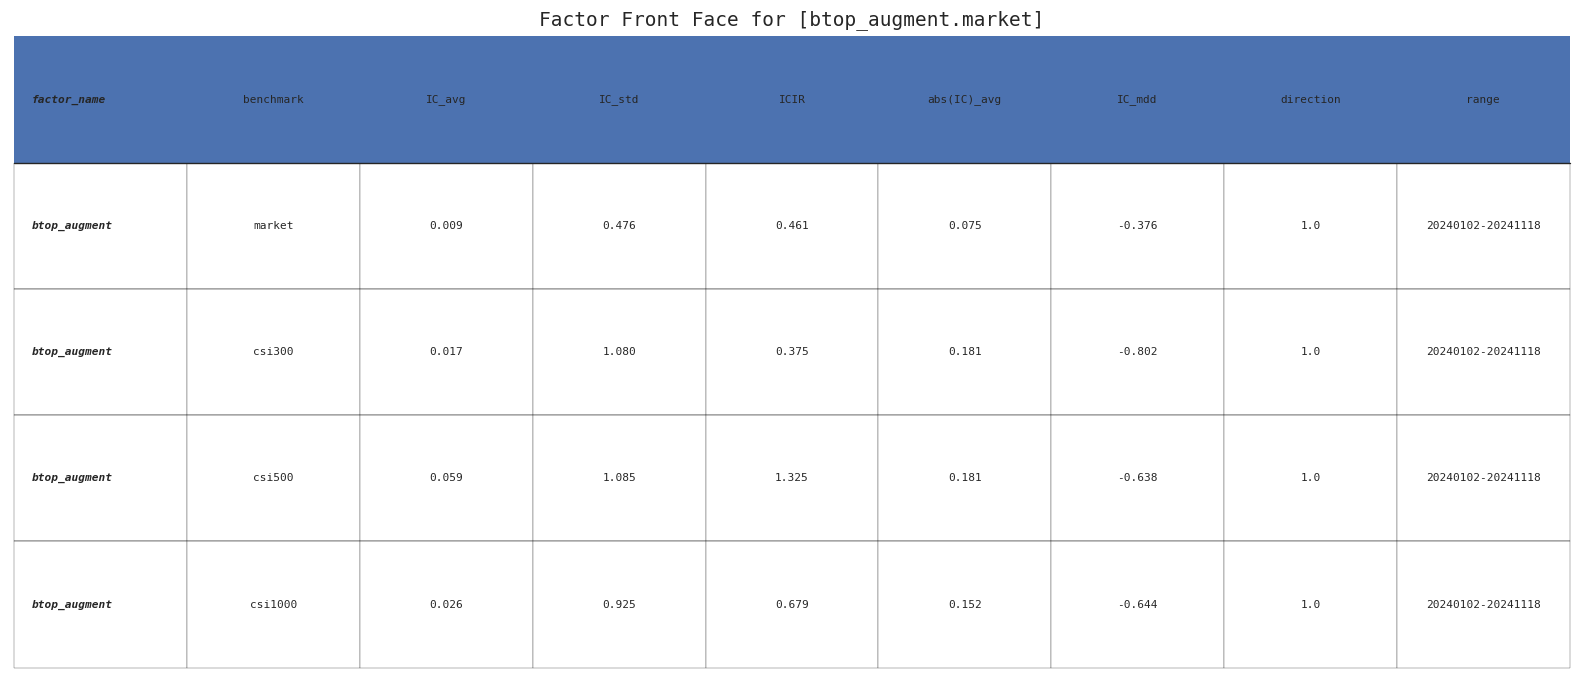

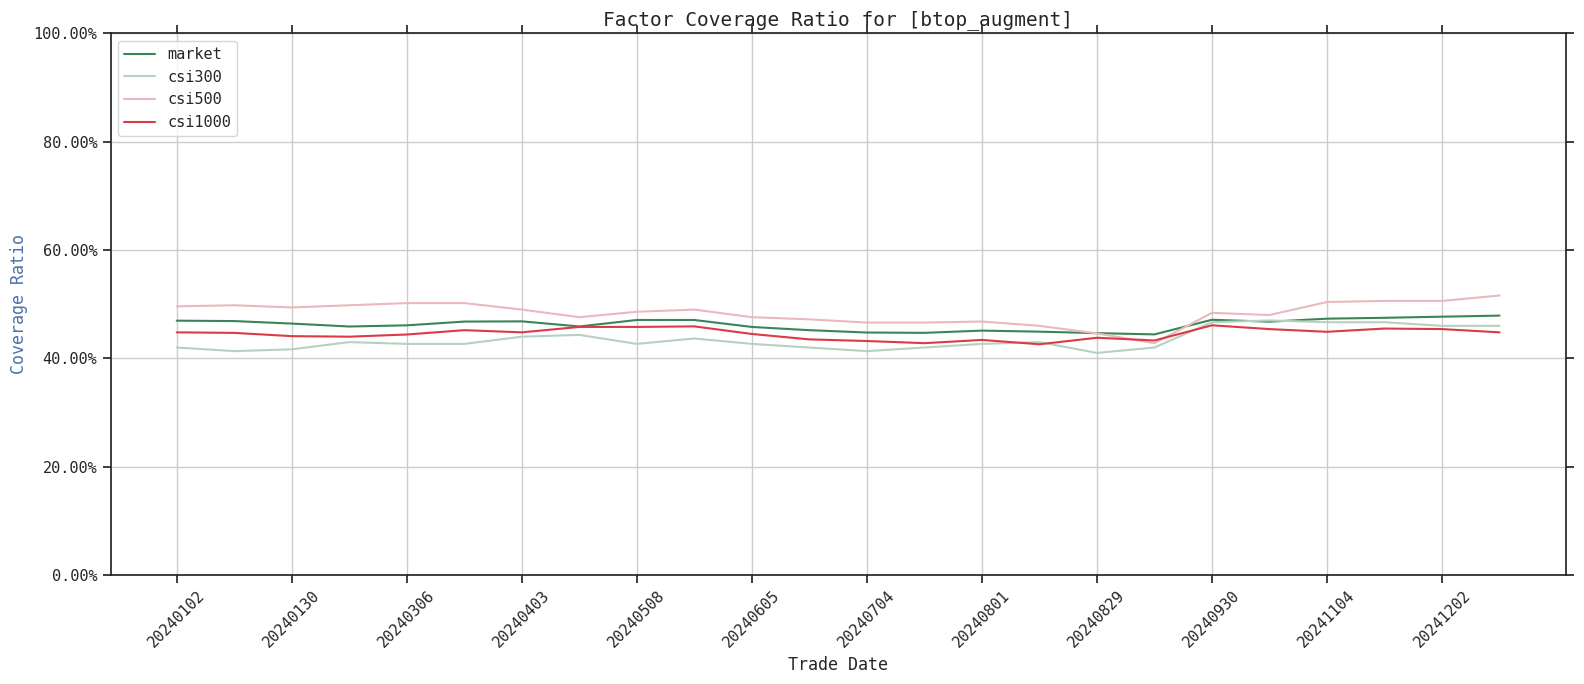

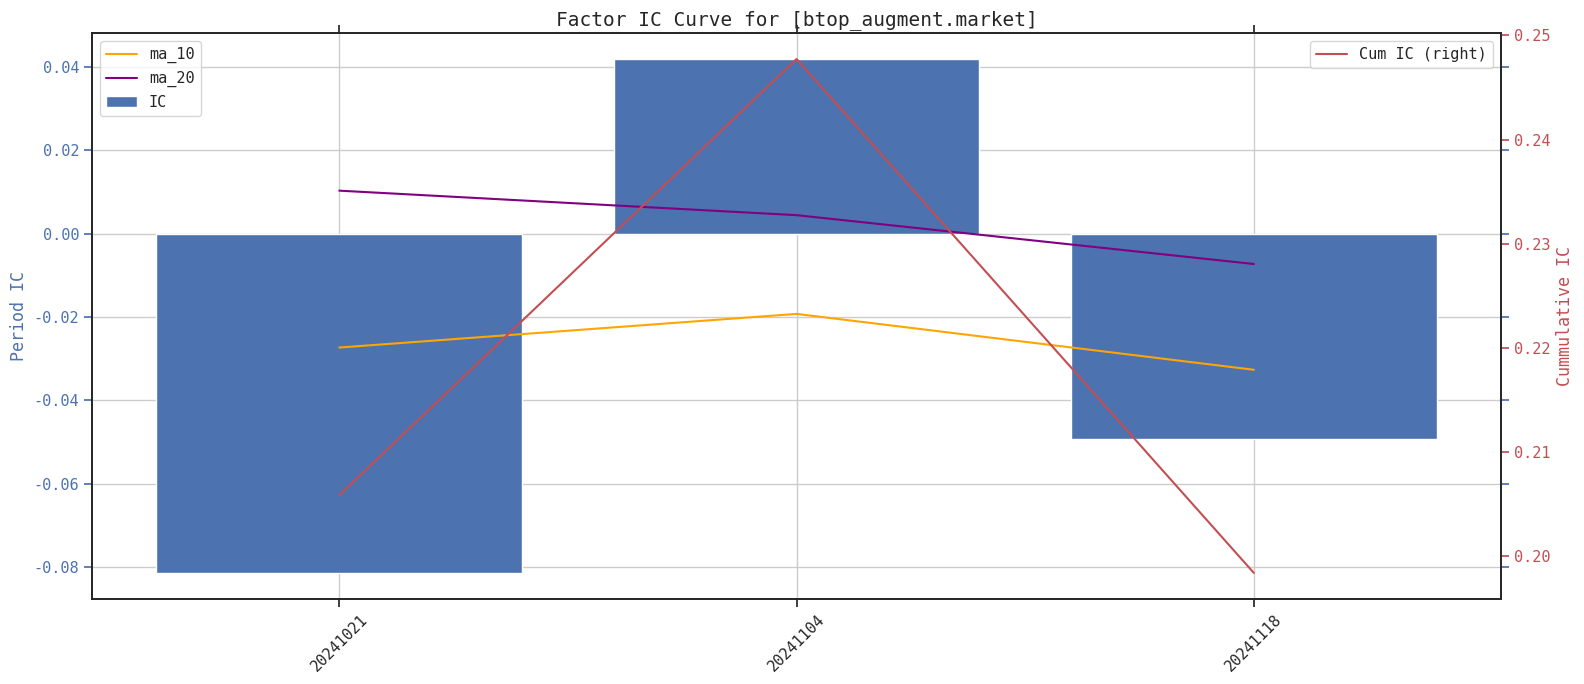

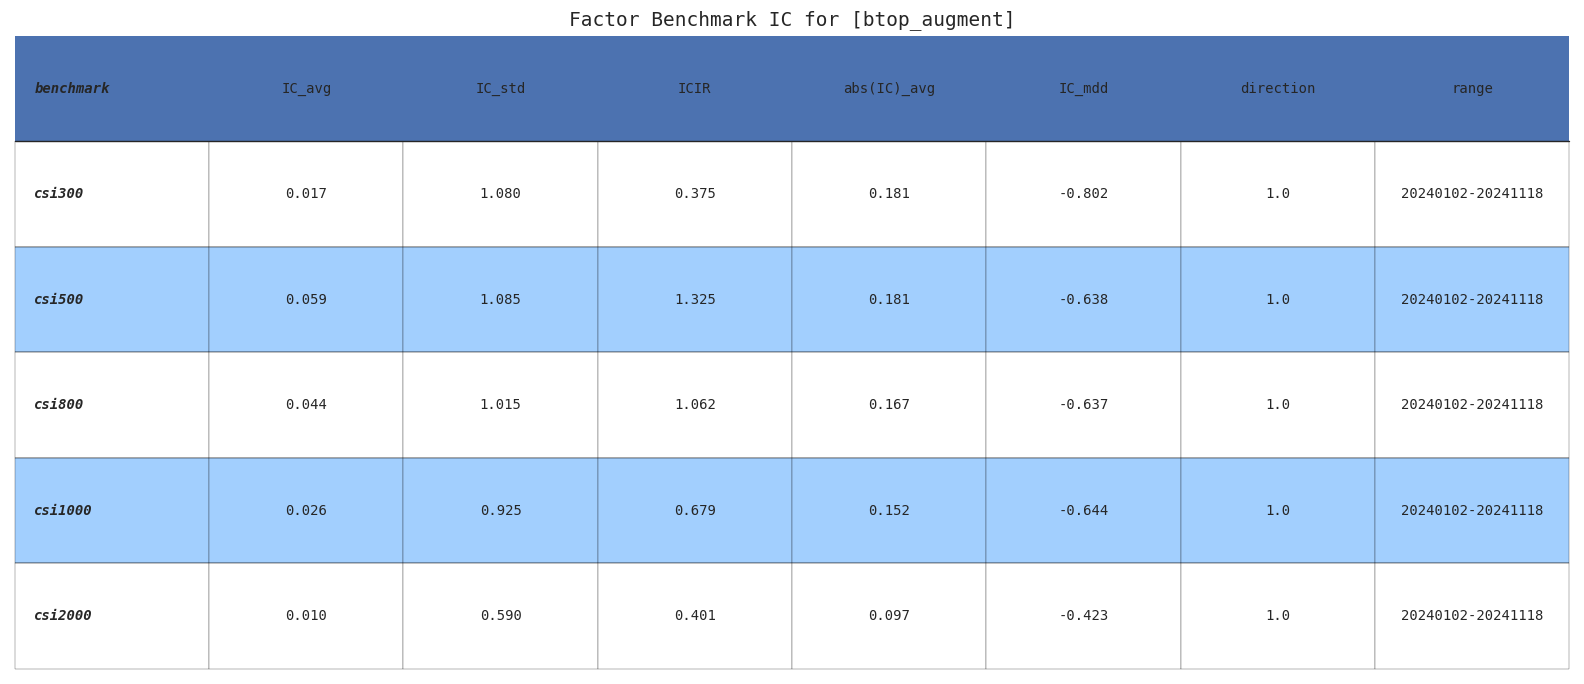

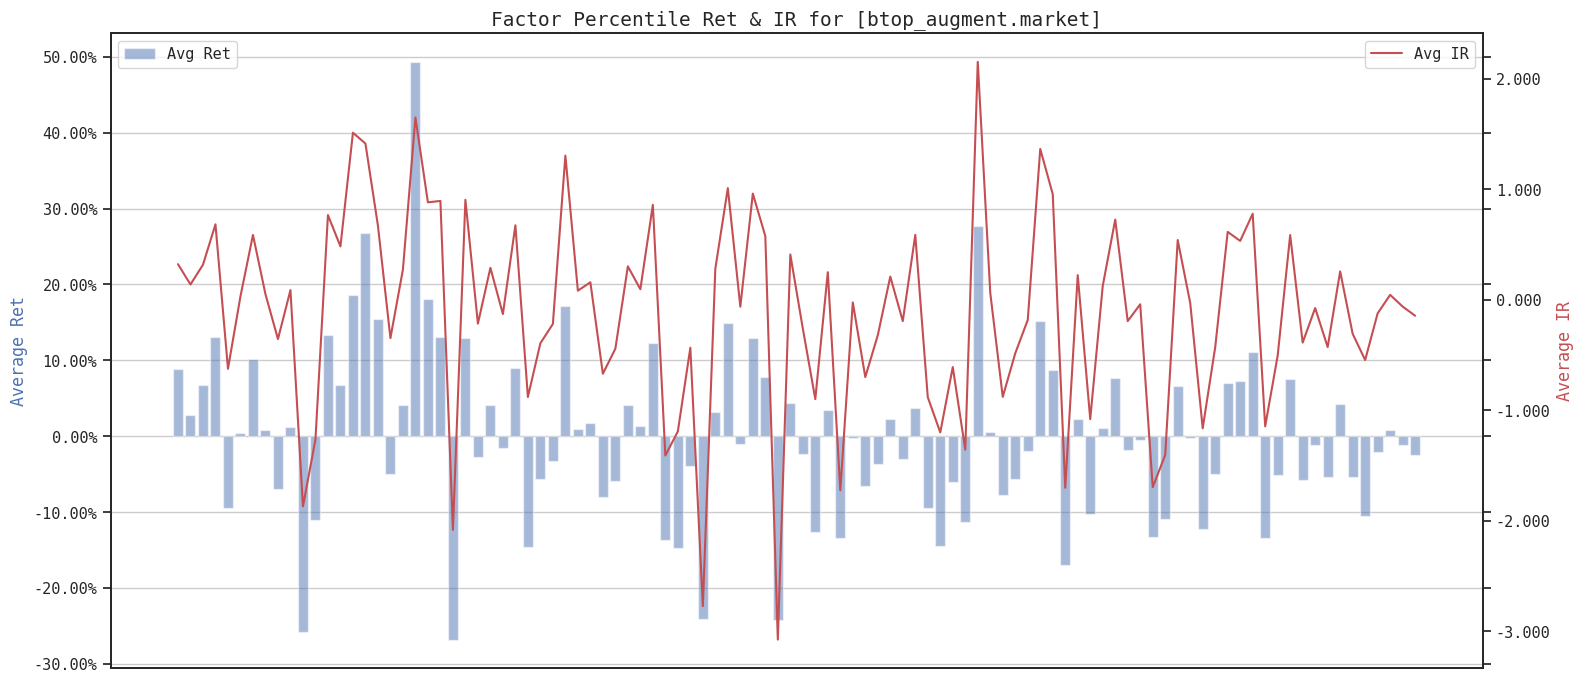

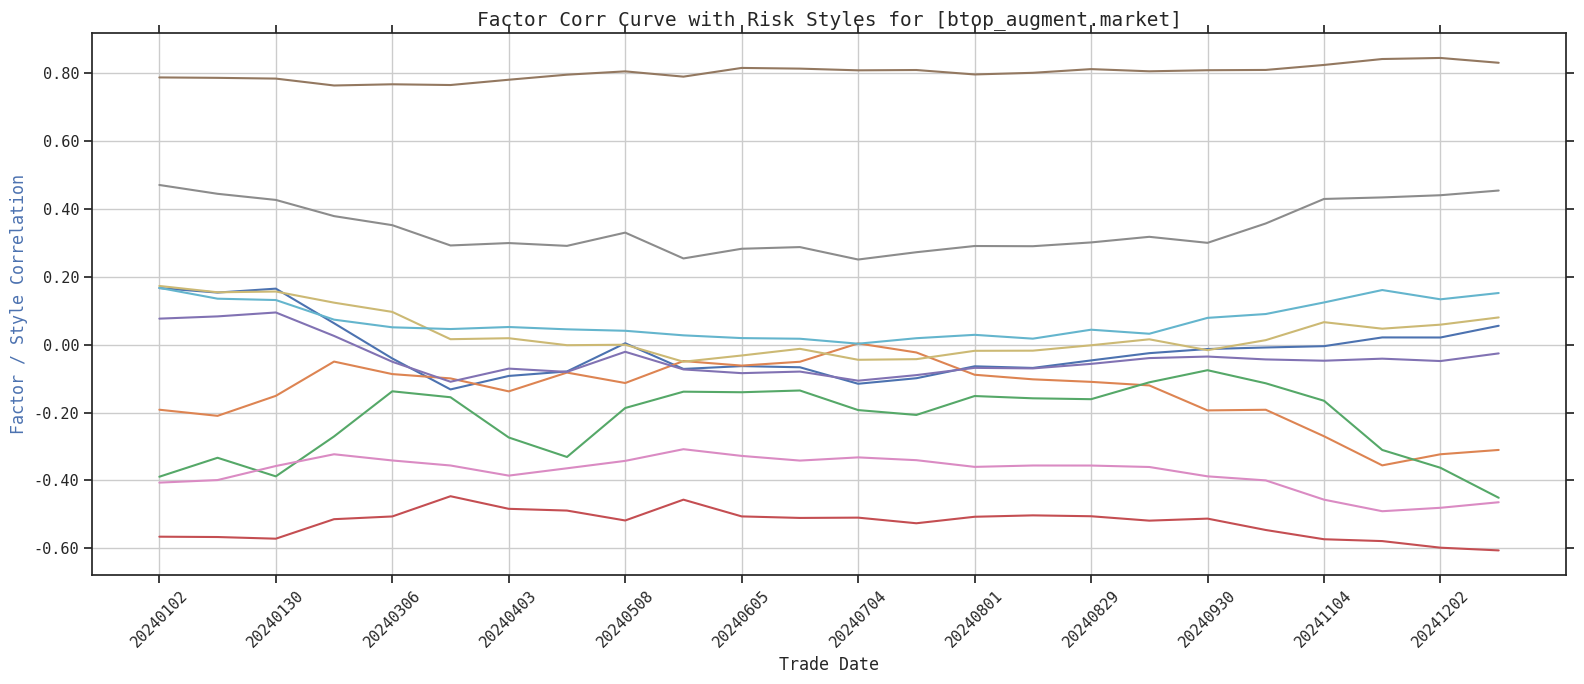

In [2]:
factor.fast_analyze()